<a href="https://colab.research.google.com/github/fhac-ewi/recurrent-neural-network/blob/Textprediction/TextPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Textvervollständigung

In [2]:
import keras
import tensorflow as tf
print("Keras Version:", keras.__version__, "; Tensorflow version:", tf.__version__)

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import os
import time
from datetime import timedelta

import matplotlib.pyplot as plt

Keras Version: 2.4.3 ; Tensorflow version: 2.3.2


In [3]:
from tensorflow.python.client import device_lib
print("Avaiable tensorflow devices")
for d in device_lib.list_local_devices():
    print(" ->", d.name, "is a", d.device_type, "(", d.physical_device_desc, ")")

Avaiable tensorflow devices
 -> /device:CPU:0 is a CPU (  )
 -> /device:XLA_CPU:0 is a XLA_CPU ( device: XLA_CPU device )
 -> /device:XLA_GPU:0 is a XLA_GPU ( device: XLA_GPU device )


In [4]:
def generate_heading(title):
  title = str(title).upper()
  return "\n".join((f"--{title}--", "_" * (len(title) + 4)))

In [7]:
def clean_book(txt):
    started = False
    after_page = False
    ret_txt = []
    for line in txt.split("\n"):
        if started:
            if after_page:
                if len(line.strip()) == 0:
                    pass
                else:
                    after_page = False
                    ret_txt.append(line)
            else:
                if line.startswith("Page | ") or line.strip() == "*":
                    after_page = True
                else:
                    ret_txt.append(line)
        else:
            if line.startswith("/") or line.startswith("I"):
                started = True
    return ("\n".join(ret_txt)).strip()

In [8]:
def save_book(idx, title, text):
    open(f"./{idx} - {title}.txt", 'wb').write(("\n\n\n\n".join((generate_heading(title), text))).encode("utf-8"))

In [9]:
books = [
    ("Harry Potter and the Philosophers stone", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%201%20-%20The%20Philosopher's%20Stone.txt"),
    ("Harry Potter ańd the Chamber Of Secrets", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%202%20-%20The%20Chamber%20of%20Secrets.txt"),
    ("Harry Potter and the Prisoner Of Azkaban", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%203%20-%20The%20Prisoner%20of%20Azkaban.txt"),
    ("Harry Potter and the Goblet Of Fire", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%204%20-%20The%20Goblet%20of%20Fire.txt"),
    ("Harry Potter and the Order Of The Phoenix", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%205%20-%20The%20Order%20of%20the%20Phoenix.txt"),
    ("Harry Potter and the Half Blood Prince", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%206%20-%20The%20Half%20Blood%20Prince.txt"),
    ("Harry Potter and the Deathly Hallows", "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%207%20-%20The%20Deathly%20Hallows.txt")
]

downloaded_files = {}
for i, (name, url) in enumerate(books):
  downloaded_files[(i, name)] = keras.utils.get_file(f"training_text_{i}.txt", url)

In [10]:
processed_texts = {}

for (i, name), path in downloaded_files.items():
    text_load = open(path, 'rb').read().decode(encoding='utf-8')
    processed_texts[name] = clean_book(text_load)
    save_book(i + 1, name, processed_texts[name])

In [11]:
text = "\n\n".join(processed_texts.values())

print(f'Length of text: {len(text)} characters')

Length of text: 6461583 characters


In [12]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

In [13]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

92 unique characters


In [14]:
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)
chars_from_ids = keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [15]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(6461583,), dtype=int64, numpy=array([48, 36, 33, ..., 68, 68, 13])>

In [16]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
ids_dataset

<TensorSliceDataset shapes: (), types: tf.int64>

In [17]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

T
H
E
 
B
O
Y
 
W
H


In [18]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'T' b'H' b'E' b' ' b'B' b'O' b'Y' b' ' b'W' b'H' b'O' b' ' b'L' b'I'
 b'V' b'E' b'D' b' ' b'\n' b'\n' b'M' b'r' b'.' b' ' b'a' b'n' b'd' b' '
 b'M' b'r' b's' b'.' b' ' b'D' b'u' b'r' b's' b'l' b'e' b'y' b',' b' '
 b'o' b'f' b' ' b'n' b'u' b'm' b'b' b'e' b'r' b' ' b'f' b'o' b'u' b'r'
 b',' b' ' b'P' b'r' b'i' b'v' b'e' b't' b' ' b'D' b'r' b'i' b'v' b'e'
 b',' b' ' b'\n' b'w' b'e' b'r' b'e' b' ' b'p' b'r' b'o' b'u' b'd' b' '
 b't' b'o' b' ' b's' b'a' b'y' b' ' b't' b'h' b'a' b't' b' ' b't' b'h'
 b'e' b'y' b' '], shape=(101,), dtype=string)


In [19]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'THE BOY WHO LIVED \n\nMr. and Mrs. Dursley, of number four, Privet Drive, \nwere proud to say that they '
b'were perfectly normal, \nthank you very much. They were the last people you\xe2\x80\x99d \nexpect to be involved i'
b'n anything strange or \nmysterious, because they just didn\xe2\x80\x99t hold with such \nnonsense. \n\nMr. Dursley w'
b'as the director of a firm called \nGrunnings, which made drills. He was a big, beefy \nman with hardly '
b'any neck, although he did have a \nvery large mustache. Mrs. Dursley was thin and \nblonde and had near'


In [20]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [21]:
dataset = sequences.map(split_input_target)
print(dataset, len(dataset) * seq_length, len(text))

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)> 6397600 6461583


In [22]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'THE BOY WHO LIVED \n\nMr. and Mrs. Dursley, of number four, Privet Drive, \nwere proud to say that they'
Target: b'HE BOY WHO LIVED \n\nMr. and Mrs. Dursley, of number four, Privet Drive, \nwere proud to say that they '


In [23]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    )

print(dataset, len(dataset) * seq_length * BATCH_SIZE, len(text))

<PrefetchDataset shapes: ((None, 100), (None, 100)), types: (tf.int64, tf.int64)> 6400000 6461583


In [24]:
VALIDATION_SIZE = 1/3

_ = int(np.ceil(len(dataset) * (1 - VALIDATION_SIZE)))
dataset_train = dataset.take(_)
dataset_val = dataset.skip(_)
print("Going to use", len(dataset_train), "batches for training and", len(dataset_val), "for validation")

Going to use 667 batches for training and 333 for validation


In [25]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [26]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units, rnn_type=tf.keras.layers.SimpleRNN):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn_layer = rnn_type(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.rnn_layer.get_initial_state(x)
        x, *states = self.rnn_layer(x, initial_state=states, training=training)
        # print(len(states), type(states))
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [27]:
model_simpleRNN = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    rnn_type=tf.keras.layers.SimpleRNN
    )

model_LSTM = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    rnn_type=tf.keras.layers.LSTM
    )

model_GRU = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    rnn_type=tf.keras.layers.GRU
    )

print("Checking output shape")
print("-" * 5, "SimpleRNN", "-" * 5)
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model_simpleRNN(input_example_batch)
    print(example_batch_predictions.shape, (BATCH_SIZE, seq_length, vocab_size))
model_simpleRNN.summary()
print()

print("-" * 5, "LSTM", "-" * 10)
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model_LSTM(input_example_batch)
    print(example_batch_predictions.shape, (BATCH_SIZE, seq_length, vocab_size))
    pass
model_LSTM.summary()

print("-" * 5, "GRU", "-" * 11)
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model_GRU(input_example_batch)
    print(example_batch_predictions.shape, (BATCH_SIZE, seq_length, vocab_size))
model_GRU.summary()

Checking output shape
----- SimpleRNN -----
(64, 100, 93) (64, 100, 92)
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  23808     
_________________________________________________________________
simple_rnn (SimpleRNN)       multiple                  1311744   
_________________________________________________________________
dense (Dense)                multiple                  95325     
Total params: 1,430,877
Trainable params: 1,430,877
Non-trainable params: 0
_________________________________________________________________

----- LSTM ----------
(64, 100, 93) (64, 100, 92)
Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  23808     
_____________________________________

In [28]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [29]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy().decode("utf-8"))
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy().decode("utf-8"))

Input:
 

“What? Where?” 

Harry had suddenly gone into a spectacular dive, 
which drew gasps and cheers fro

Next Char Predictions:
 /b7.rz.\eMy0aHaB/2FNY4r"/1(Z/*gg9UP!B5fdVRFt
jf>tY□UHqslFmG0-c-8QS?”rJD’ jt4cK"‘Z‘(V992Q5LA11:&QR5Nv


In [30]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [31]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape, (BATCH_SIZE, seq_length, vocab_size))
print("Mean loss:        ", mean_loss)

Prediction shape:  (64, 100, 93) (64, 100, 92)
Mean loss:         4.5318313


In [32]:
print(tf.exp(mean_loss).numpy(), "should be around or higher", vocab_size)

92.92858 should be around or higher 92


In [33]:
class OwnAccuracy(keras.metrics.Metric):
    def __init__(self, name="accuracy", **kwargs):
        super(OwnAccuracy, self).__init__(name=name, **kwargs)
        self.accuracy = self.add_weight(name="acc", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = np.argmax(y_pred.numpy(), axis=2)
        y_true = y_true.numpy()
        correct = np.sum(y_pred == y_true, axis=1)
        self.accuracy.assign(np.mean(correct / y_true.shape[1]))

    def result(self):
        return self.accuracy

    def reset_states(self):
        self.accuracy.assign(0.0)

In [34]:
model_simpleRNN.compile(optimizer='adam', loss=loss, metrics=[OwnAccuracy()], run_eagerly=True)
model_LSTM.compile(optimizer='adam', loss=loss, metrics=[OwnAccuracy()], run_eagerly=True)
model_GRU.compile(optimizer='adam', loss=loss, metrics=[OwnAccuracy()], run_eagerly=True)

In [35]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_simple_{epoch}")
checkpoint_callback_simple = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_lstm_{epoch}")
checkpoint_callback_lstm = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_gru_{epoch}")
checkpoint_callback_gru = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

In [36]:
model_use = model_GRU

In [37]:
EPOCHS = 10

In [38]:
start = time.time()
history = model_use.fit(dataset_train, epochs=EPOCHS, validation_data=dataset_val)
end = time.time()

print("Training took", timedelta(seconds=end-start))

Epoch 1/10
  9/667 [..............................] - ETA: 29:03 - loss: 4.6530 - accuracy: 0.1256

KeyboardInterrupt: 

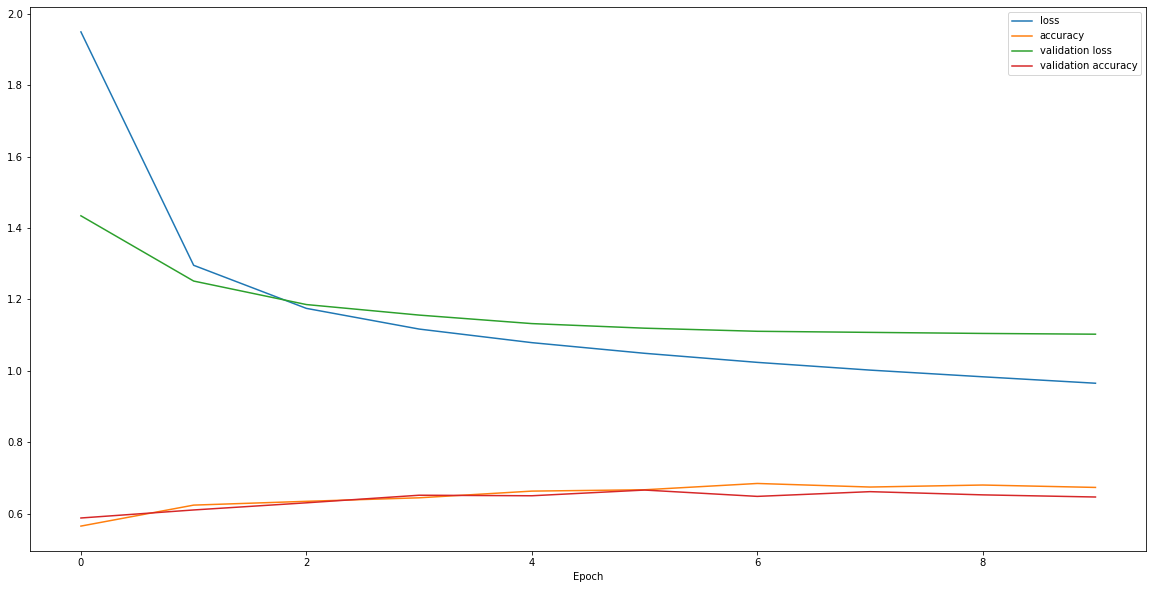

In [36]:
fig, ax = plt.subplots(1, 1)

ax.plot(history.history["loss"], label='loss')
ax.plot(history.history["accuracy"], label='accuracy')
ax.plot(history.history["val_loss"], label='validation loss')
ax.plot(history.history["val_accuracy"], label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

In [37]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())]
        )
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [38]:
one_step = OneStep(model_use, chars_from_ids, ids_from_chars)

In [39]:
def generate_text(initial_chars, amount_generation, one_step_model):
  start = time.time()
  states = None
  next_char = tf.constant([initial_chars])
  result = [next_char]

  for n in range(amount_generation):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)
    if (n+1) % 10000 == 0:
      print("Generation step", n+1, "/", amount_generation)

  result = tf.strings.join(result)
  end = time.time()
  return result[0].numpy().decode('utf-8'), end - start

In [40]:
generated_book_title = "Harry Potter and Learned Machine"
generated_book_len = np.random.randint(min(len(x) for x in processed_texts.values()), max(len(x) for x in processed_texts.values()) + 1)
generated_book_first = "The redemption\n\n".upper()

generated_book_len = 20_000

generated_text, t = generate_text(initial_chars=generated_book_first, amount_generation=generated_book_len, one_step_model=one_step)
print("-" * 25)
save_book(len(books) + 1, generated_book_title, generated_text)
print(generated_text[:1000])
print("-" * 25)
print("Run time:", timedelta(seconds=t))
print("-" * 25)

Generation step 10000 / 20000
Generation step 20000 / 20000
-------------------------
THE REDEMPTION


The girls hurtled together, ninerce up and then 
were painful. 

“Nice difficult told as anyone, that’s very enjoyable.” 

“You’re quite that dam got to hers here,” she peered. “Luterin’ 
things, Colin. 

“I don’t need me particular rage.” 

“No,” said Harry, a little there with his moment 
he looked up to suspition with the saldom, but as 
he surveyed Hermione, the man staggering. “Of course!” 

“But I mean, the other had no proof safes,” said 
Hermione briskly. “It’s swelling batly for it!” 

“What’re you because he’s quite using?” they all stifled a little 
fine, turned back toward Stan. 

Entolt; Harry healed off about Wormtail and 
its either of them was together as he had reached the 

chair, which Harry was halfway toward the snowy spectacle 
from his usual sleet. The empty hair each 
face mand of warm that night. He appeared there all 
madenings, “Merilly when you have an appa